In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [95]:
responses = pd.read_csv('responses.csv').drop('Timestamp', 1)
responses.head()

,1. Má človek na obrázku okuliare?,2. Má človek na obrázku okuliare?,3. Má človek na obrázku okuliare?,4. Má človek na obrázku okuliare?,5. Má človek na obrázku okuliare?,6. Má človek na obrázku okuliare?,7. Má človek na obrázku okuliare?,8. Má človek na obrázku okuliare?,9. Má človek na obrázku okuliare?,10. Má človek na obrázku okuliare?,...,"17. Zdá sa byť človek na obrázku skôr mladší, alebo skôr starší?",18. Usmieva sa človek na obrázku?,"18. Podobá sa človek na obrázku skôr na ženu, alebo skôr na muža?.1","18. Zdá sa byť človek na obrázku skôr mladší, alebo skôr starší?",19. Usmieva sa človek na obrázku?,"19. Podobá sa človek na obrázku skôr na ženu, alebo skôr na muža?.1","19. Zdá sa byť človek na obrázku skôr mladší, alebo skôr starší?",20. Usmieva sa človek na obrázku?,"20. Podobá sa človek na obrázku skôr na ženu, alebo skôr na muža?.1","20. Zdá sa byť človek na obrázku skôr mladší, alebo skôr starší?"
0,"Áno, človek na obrázku má okuliare","Áno, človek na obrázku má okuliare","Áno, človek na obrázku má okuliare","Áno, človek na obrázku má okuliare","Áno, človek na obrázku má okuliare","Nie, človek na obrázku nemá okuliare","Áno, človek na obrázku má okuliare","Nie, človek na obrázku nemá okuliare","Nie, človek na obrázku nemá okuliare","Áno, človek na obrázku má okuliare",...,Človek na obrázku sa zdá byť skôr mladší,"Áno, človek na obrázku sa usmieva",Človek na obrázku sa podobá skôr na ženu,Človek na obrázku sa zdá byť skôr mladší,"Áno, človek na obrázku sa usmieva",Človek na obrázku sa podobá skôr na ženu,Človek na obrázku sa zdá byť skôr mladší,"Nie, človek na obrázku sa neusmieva",Človek na obrázku sa podobá skôr na muža,Človek na obrázku sa zdá byť skôr starší
1,"Áno, človek na obrázku má okuliare","Nie, človek na obrázku nemá okuliare","Áno, človek na obrázku má okuliare","Áno, človek na obrázku má okuliare","Áno, človek na obrázku má okuliare","Nie, človek na obrázku nemá okuliare","Áno, človek na obrázku má okuliare","Nie, človek na obrázku nemá okuliare","Nie, človek na obrázku nemá okuliare","Áno, človek na obrázku má okuliare",...,Človek na obrázku sa zdá byť skôr mladší,"Áno, človek na obrázku sa usmieva",Človek na obrázku sa podobá skôr na ženu,Človek na obrázku sa zdá byť skôr mladší,"Áno, človek na obrázku sa usmieva",Človek na obrázku sa podobá skôr na ženu,Človek na obrázku sa zdá byť skôr mladší,"Nie, človek na obrázku sa neusmieva",Človek na obrázku sa podobá skôr na muža,Človek na obrázku sa zdá byť skôr starší
2,"Áno, človek na obrázku má okuliare","Nie, človek na obrázku nemá okuliare","Áno, človek na obrázku má okuliare","Áno, človek na obrázku má okuliare","Áno, človek na obrázku má okuliare","Nie, človek na obrázku nemá okuliare","Áno, človek na obrázku má okuliare","Nie, človek na obrázku nemá okuliare","Nie, človek na obrázku nemá okuliare","Áno, človek na obrázku má okuliare",...,Človek na obrázku sa zdá byť skôr mladší,"Áno, človek na obrázku sa usmieva",Človek na obrázku sa podobá skôr na ženu,Človek na obrázku sa zdá byť skôr mladší,"Áno, človek na obrázku sa usmieva",Človek na obrázku sa podobá skôr na ženu,Človek na obrázku sa zdá byť skôr mladší,"Nie, človek na obrázku sa neusmieva",Človek na obrázku sa podobá skôr na muža,Človek na obrázku sa zdá byť skôr starší
3,"Áno, človek na obrázku má okuliare","Nie, človek na obrázku nemá okuliare","Áno, človek na obrázku má okuliare","Áno, človek na obrázku má okuliare","Áno, človek na obrázku má okuliare","Nie, človek na obrázku nemá okuliare","Áno, človek na obrázku má okuliare","Nie, človek na obrázku nemá okuliare","Nie, človek na obrázku nemá okuliare","Áno, človek na obrázku má okuliare",...,Človek na obrázku sa zdá byť skôr mladší,"Áno, človek na obrázku sa usmieva",Človek na obrázku sa podobá skôr na ženu,Človek na obrázku sa zdá byť skôr mladší,"Áno, človek na obrázku sa usmieva",Človek na obrázku sa podobá skôr na ženu,Človek na obrázku sa zdá byť skôr mladší,"Z obrázku neviem povedať, či sa človek na obrá...",Človek na obrázku sa

In [96]:
# eyeglasses
responses_1cat = responses.iloc[:,:20].replace('Áno, človek na obrázku má okuliare', 1.0)\
                                      .replace('Nie, človek na obrázku nemá okuliare', 0.0)\
                                      .replace('Z obrázku neviem povedať, či človek má, alebo nemá okuliare', 0.5)

# beard + male
responses_2cat = responses.iloc[:,20:60].replace('Áno, človek na obrázku má bradu', 1.0)\
                                        .replace('Nie, človek na obrázku nemá bradu', 0.0)\
                                        .replace('Z obrázku neviem povedať, či človek má, alebo nemá bradu', 0.5)\
                                        .replace('Človek na obrázku sa podobá skôr na ženu', 0.0)\
                                        .replace('Človek na obrázku sa podobá skôr na muža', 1.0)\
                                        .replace('Z obrázku neviem povedať, či sa človek podobá skôr na ženu, alebo na muža', 0.5)

# smile + female + young
responses_3cat = responses.iloc[:,60:120].replace('Áno, človek na obrázku sa usmieva', 1.0)\
                                         .replace('Nie, človek na obrázku sa neusmieva', 0.0)\
                                         .replace('Z obrázku neviem povedať, či sa človek na obrázku usmieva, alebo neusmieva', 0.5)\
                                         .replace('Človek na obrázku sa podobá skôr na ženu', 1.0)\
                                         .replace('Človek na obrázku sa podobá skôr na muža', 0.0)\
                                         .replace('Z obrázku neviem povedať, či sa človek podobá skôr na ženu, alebo na muža', 0.5)\
                                         .replace('Človek na obrázku sa zdá byť skôr mladší', 1.0)\
                                         .replace('Človek na obrázku sa zdá byť skôr starší', 0.0)\
                                         .replace('Z obrázku neviem povedať, či je človek skôr mladší, alebo starší', 0.5)

In [97]:
def plot_less_than(df, percent):
    colors = ['#ff9999','#66b3ff','#99ff99']
    count = 0
    colnames = []
    
    for i, colname in enumerate(df):
        vals = df[colname].value_counts().values
        if (max(vals)/sum(vals) > percent):
            continue

        count += 1
        #colnames.append(int(colname.split('.')[0]))
        colnames.append(colname)
        fig1, ax1 = plt.subplots()
        explode = None

        df[colname].value_counts().plot.pie(colors = colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)

        centre_circle = plt.Circle((0,0),0.70,fc='white')
        fig = plt.gcf()
        fig.gca().add_artist(centre_circle)

        ax1.axis('equal')  
        plt.tight_layout()
        plt.title('img-' + str(i+1))
        plt.show()
    
    return (count, colnames)

In [98]:
threshold = 0.8

eyeglasses_count, eyeglasses_colnames = plot_less_than(responses_1cat, threshold)
df_cat1_neutral_count = pd.DataFrame({'Only Eyeglasses': [eyeglasses_count]},['Eyeglasses'])

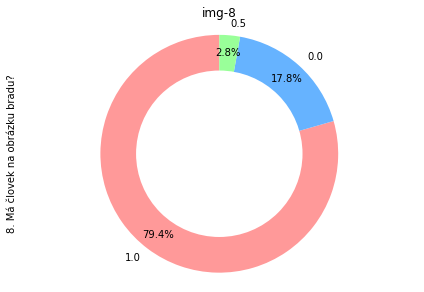

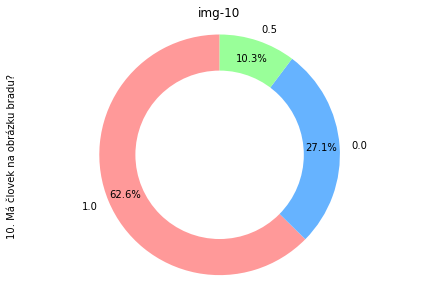

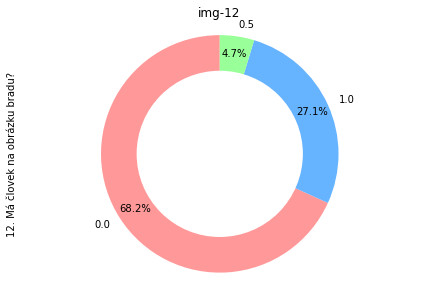

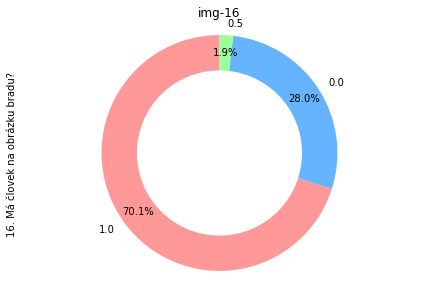

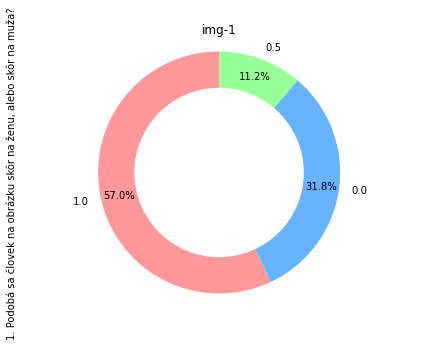

In [104]:
male_count, male_colnames = plot_less_than(responses_2cat[responses_2cat.columns[::2]], threshold)
beard_count, beard_colnames = plot_less_than(responses_2cat[responses_2cat.columns[1::2]], threshold)

df_cat2_neutral_count = pd.DataFrame({'Male and beard': [beard_count, male_count]}, ['Male', 'Beard'])

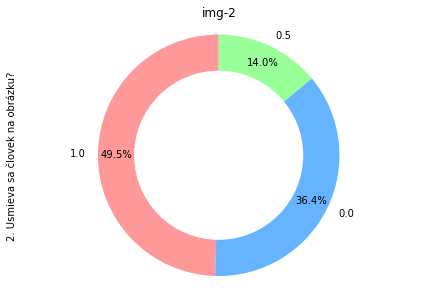

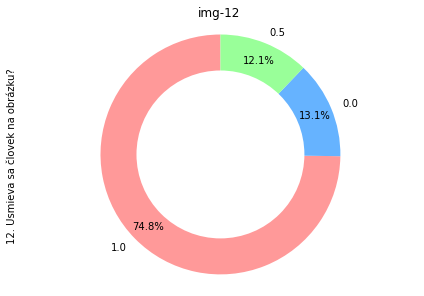

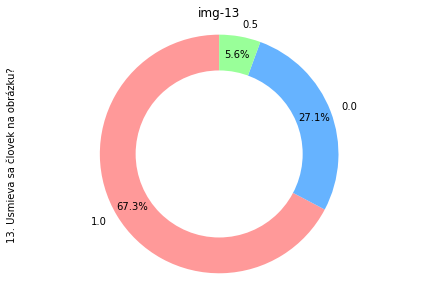

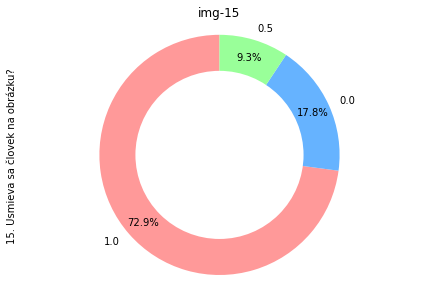

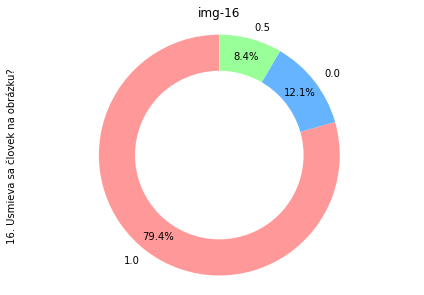

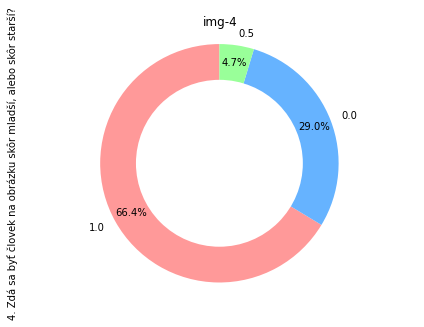

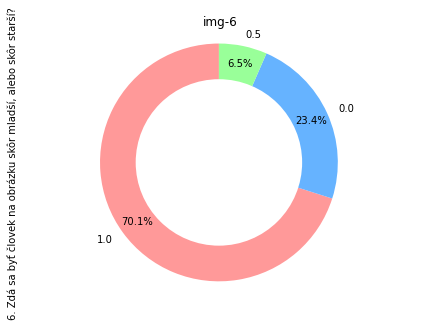

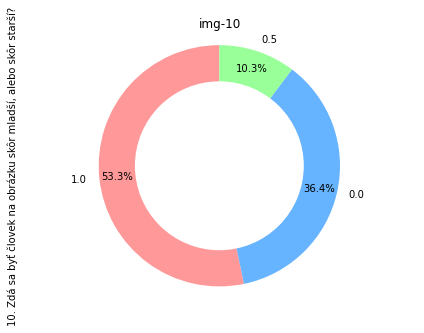

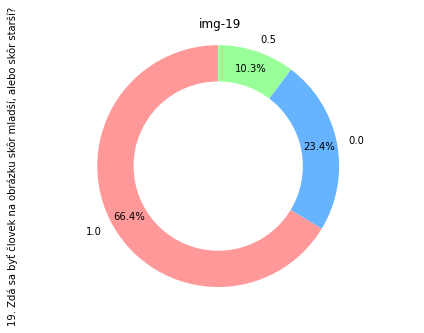

In [119]:
smile_count, smile_colnames = plot_less_than(responses_3cat[responses_3cat.columns[::3]], threshold)
young_count, young_colnames = plot_less_than(responses_3cat[responses_3cat.columns[2::3]], threshold)
female_count, female_colnames = plot_less_than(responses_3cat[responses_3cat.columns[1::3]], threshold)

df_cat3_neutral_count = pd.DataFrame({'Smile, young and female': [smile_count, young_count, female_count]}, ['Smile', 'Young', 'Female'])

In [120]:
df_cat1_neutral_count

,Only Eyeglasses
Eyeglasses,0


In [121]:
df_cat2_neutral_count

,Male and beard
Male,1
Beard,4


In [122]:
df_cat3_neutral_count

,"Smile, young and female"
Smile,5
Young,4
Female,0


In [123]:
print('Not relevand responses count: ' + str(male_count + beard_count + eyeglasses_count + smile_count + young_count + female_count))

Not relevand responses count: 14


In [124]:
relevant_responses_1cat = responses_1cat.drop(eyeglasses_colnames, 1)
relevant_responses_2cat = responses_2cat.drop(male_colnames + beard_colnames, 1) 
relevant_responses_3cat = responses_3cat.drop(smile_colnames + young_colnames + female_colnames, 1)

In [136]:
def split_methods(df):
    linear = df.filter(regex='^[1-9]\.')
    arctanh = df.filter(regex='^(1[1-9])')
    
    return (linear, arctanh)

In [140]:
linear_1cat, arctanh_1cat = split_methods(relevant_responses_1cat)
linear_2cat, arctanh_2cat = split_methods(relevant_responses_2cat)
linear_3cat, arctanh_3cat = split_methods(relevant_responses_3cat)

In [252]:
def get_accuracy(attributes):
    acc = []
    for attr in attributes:
        val = 0 
        counter = 0

        for colname in attr:
            val += attr[colname].mode().values[0]
            counter += 1

        acc.append(val/counter*100)
        
    return acc

In [261]:
pd.DataFrame({'Eyeglasses': [get_accuracy([linear_1cat])[0], get_accuracy([arctanh_1cat])[0]]}, ['Linear', 'Arctanh'])

,Eyeglasses
Linear,55.555556
Arctanh,66.666667


In [262]:
linear = get_accuracy([linear_2cat.filter(regex='muža'), linear_2cat.filter(regex='bradu')])
arctanh = get_accuracy([arctanh_2cat.filter(regex='muža'), arctanh_2cat.filter(regex='bradu')])
pd.DataFrame({'Male': [linear[0], arctanh[0]], 'Beard': [linear[1], arctanh[1]]}, ['Linear', 'Arctanh'])

,Male,Beard
Linear,100.0,50.0
Arctanh,100.0,100.0


In [263]:
linear = get_accuracy([linear_3cat.filter(regex='Usmieva'), linear_3cat.filter(regex='muža'), linear_3cat.filter(regex='starší')])
arctanh = get_accuracy([arctanh_3cat.filter(regex='Usmieva'), arctanh_3cat.filter(regex='muža'), arctanh_3cat.filter(regex='starší')])
pd.DataFrame({'Smile': [linear[0], arctanh[0]], 'Female': [linear[1], arctanh[1]], 'Young': [linear[2], arctanh[2]]}, ['Linear', 'Arctanh'])

,Smile,Female,Young
Linear,100.0,100.0,100.0
Arctanh,100.0,100.0,100.0


In [251]:
# thesis_df = responses_3cat['2. Usmieva sa človek na obrázku?'].rename('')
# my_dpi = 120
# fig1, ax1 = plt.subplots(figsize=(1024/my_dpi, 1024/my_dpi), dpi=my_dpi)
# explode = None
# colors = ['#ff9999','#66b3ff','#99ff99']

# thesis_df.value_counts().plot.pie(colors = colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode, textprops={'fontsize': 20, 'fontweight': 'bold'})

# centre_circle = plt.Circle((0,0),0.70,fc='white')
# fig = plt.gcf()
# fig.gca().add_artist(centre_circle)

# ax1.axis('equal')
# plt.tight_layout()
# plt.title('Is the person on the image smiling?', y=0.95, fontsize=26, fontweight='bold')
# plt.show()

In [270]:
linear_1cat, arctanh_1cat = split_methods(responses_1cat)
linear_2cat, arctanh_2cat = split_methods(responses_2cat)
linear_3cat, arctanh_3cat = split_methods(responses_3cat)

In [272]:
arctanh_3cat

,11. Usmieva sa človek na obrázku?,"11. Podobá sa človek na obrázku skôr na ženu, alebo skôr na muža?.1","11. Zdá sa byť človek na obrázku skôr mladší, alebo skôr starší?",12. Usmieva sa človek na obrázku?,"12. Podobá sa človek na obrázku skôr na ženu, alebo skôr na muža?.1","12. Zdá sa byť človek na obrázku skôr mladší, alebo skôr starší?",13. Usmieva sa človek na obrázku?,"13. Podobá sa človek na obrázku skôr na ženu, alebo skôr na muža?.1","13. Zdá sa byť človek na obrázku skôr mladší, alebo skôr starší?",14. Usmieva sa človek na obrázku?,...,"16. Zdá sa byť človek na obrázku skôr mladší, alebo skôr starší?",17. Usmieva sa človek na obrázku?,"17. Podobá sa človek na obrázku skôr na ženu, alebo skôr na muža?.1","17. Zdá sa byť človek na obrázku skôr mladší, alebo skôr starší?",18. Usmieva sa človek na obrázku?,"18. Podobá sa človek na obrázku skôr na ženu, alebo skôr na muža?.1","18. Zdá sa byť človek na obrázku skôr mladší, alebo skôr starší?",19. Usmieva sa človek na obrázku?,"19. Podobá sa človek na obrázku skôr na ženu, alebo skôr na muža?.1","19. Zdá sa byť človek na obrázku skôr mladší, alebo skôr starší?"
0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,0.5,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,1.0,1.0,1.0,1.0,1.0,0.5,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
103,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
104,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
105,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [298]:
def get_accuracy_one(df_one):
    val = 0
    for one_colname in df_one:
        if df_one[one_colname].mode().values[0] == 1.0:
            val += 1
    
    return val/9*100

In [299]:
def get_accuracy_two(df_one, df_two):
    val = 0
    for one_colname in df_one:
        for two_colname in df_two:
            if int(one_colname.split('.')[0]) == int(two_colname.split('.')[0]):
                if df_one[one_colname].mode().values[0] == 1.0 and df_two[two_colname].mode().values[0] == 1.0:
                    val += 1            
    return val/9*100

In [300]:
def get_accuracy_three(df_one, df_two, df_three):
    val = 0
    for one_colname in df_one:
        for two_colname in df_two:
            for three_colname in df_three:
                if int(one_colname.split('.')[0]) == int(two_colname.split('.')[0]) == int(three_colname.split('.')[0]):
                    if df_one[one_colname].mode().values[0] == 1.0 and df_two[two_colname].mode().values[0] == 1.0 and df_three[three_colname].mode().values[0] == 1.0:
                        val += 1            
    return val/9*100

In [306]:
linear = get_accuracy_one(linear_1cat)
arctanh = get_accuracy_one(arctanh_1cat)
pd.DataFrame({'Eyeglasses': [linear, arctanh]}, ['Linear', 'Arctanh']).to_latex()

'\\begin{tabular}{lr}\n\\toprule\n{} &  Eyeglasses \\\\\n\\midrule\nLinear  &   55.555556 \\\\\nArctanh &   66.666667 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [305]:
linear = get_accuracy_two(linear_2cat.filter(regex='muža'), linear_2cat.filter(regex='bradu'))
arctanh = get_accuracy_two(arctanh_2cat.filter(regex='muža'), arctanh_2cat.filter(regex='bradu'))
pd.DataFrame({'Male and Beard': [linear, arctanh]}, ['Linear', 'Arctanh']).to_latex()

'\\begin{tabular}{lr}\n\\toprule\n{} &  Male and Beard \\\\\n\\midrule\nLinear  &       55.555556 \\\\\nArctanh &       88.888889 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [304]:
linear = get_accuracy_three(linear_3cat.filter(regex='Usmieva'), linear_3cat.filter(regex='muža'), linear_3cat.filter(regex='starší'))
arctanh = get_accuracy_three(arctanh_3cat.filter(regex='Usmieva'), arctanh_3cat.filter(regex='muža'), arctanh_3cat.filter(regex='starší'))
pd.DataFrame({'Smile, Female and Young': [linear, arctanh]}, ['Linear', 'Arctanh']).to_latex()

'\\begin{tabular}{lr}\n\\toprule\n{} &  Smile, Female and Young \\\\\n\\midrule\nLinear  &                    100.0 \\\\\nArctanh &                    100.0 \\\\\n\\bottomrule\n\\end{tabular}\n'